Todo</br>
verify final_price and update jason

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transfroms
from google.colab import drive
import os
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
import tensorflow as tf
!pip install pymongo[srv]
import pymongo
import pprint
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
BASE_DIR = '/content/drive/My Drive/LAO' #CNN model path
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
!python --version

True
cuda
Python 3.7.13


In [88]:
#Loading test data
batch_size = 100
num_classes = 10 # 0~9
test_set = torchvision.datasets.MNIST(
    root = BASE_DIR,
    train = False,
    download = False,
    transform = transfroms.Compose([
        transfroms.ToTensor() #Data Normalization
    ])
)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [89]:
#CNN model structure
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.conv1 = nn.Sequential(
      nn.Conv2d(1, 10, 5, padding = 2),
      nn.BatchNorm2d(10),
      nn.ReLU(inplace=True),
      nn.Conv2d(10, 20, 5),
      nn.BatchNorm2d(20),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, 2),
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(20, 40, 5, padding = 2),
      nn.BatchNorm2d(40),
      nn.ReLU(inplace=True),
      nn.Conv2d(40, 80, 5),
      nn.BatchNorm2d(80),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, 2),
    )

    self.fc_net = nn.Sequential(
      nn.Dropout2d(p=0.25, inplace=False),
      nn.Linear(80 * 4 * 4, 100),
      nn.BatchNorm1d(100),
      nn.ReLU(inplace=True),
      nn.Linear(100, num_classes),
    ) # channel * W * H for first linear(FC) parameter

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(-1, 80 * 4 * 4) #2D -> flat
    x = self.fc_net(x)

    return F.log_softmax(x)

In [90]:
#Loading pretrained CNN model
cwd = os.getcwd()
dbPATH = os.path.join(cwd,"drive/My Drive/LAO/pydb.txt")
PATH = os.path.join(cwd,"drive/My Drive/LAO/LAO.pth")
tablePath = os.path.join(cwd,"drive/My Drive/LAO/itemTable.npy")
model = torch.load(PATH)
itemTable = np.load(tablePath)
model.eval()

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(40, 80, kernel_size=(5, 5), stride=(1, 1))
    (4): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_net): Sequential(
    (0): D

In [91]:
#test model
with torch.no_grad():
    correct = 0
    total = 0

    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        out = model(data)
        preds = torch.max(out.data, 1)[1]
        total += len(target)
        correct += (preds==target).sum().item()
        
    print('Test Accuracy: ', 100.*correct/total, '%')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Accuracy:  99.51 %


In [92]:
def get_prices(img,device,model,prices,page):
  y_st = 484 #starting y coordinate
  y_ed = 541 #ending y coordinate
  y_gap = y_ed - y_st
  x_gap = 11
  for i in range(10): # 10 items per page
    x_st = 1507 #recent price starting x coordinate
    x_ed = 1519 #recent price ending x coordinate
    #x_st = 1668 #lowest price
    #x_ed = 1680 #lowest price
    digit = 0
    price = torch.zeros(4,1,28,28) #4 digits 1x28x28 images
    for j in range(4): # maximum 4 digits
      im = img[y_st+21:y_ed-21,x_st:x_ed] #crop image
      im = resizing(im) #28x28 resizing
      if np.sum(im) == 0.0: #detecting blank
        break #move to next item
      else:
        digit += 1
      cv2_imshow(im)
      print()
      newim = im/255 #image normalization
      price[j,0,:,:] = torch.from_numpy(newim)
      #move to next digit
      x_st -= x_gap
      x_ed -= x_gap
    value = predict(price[:digit,:,:,:],device,model).tolist()
    print(value)
    p = ""
    for d in value[-1::-1]: #reverse order
      p += str(d)
    p = int(p)
    prices[page,i] = p
    if page == 3 and i == 5:
      break #4th page has only 6 items
    #move to next line
    y_st = y_ed
    y_ed += y_gap

def get_crystal_price(img,device,model):
  y_st = 833
  y_ed = 851
  x_st = 1696
  x_ed = 1710
  x_gap = x_ed - x_st - 1
  digit = 0
  price = torch.zeros(4,1,28,28)
  for i in range(4): #maximum 4 digits
    im = img[y_st:y_ed,x_st:x_ed]
    im = resizing(im)
    if np.sum(im) == 0.0:
      break
    else:
      digit += 1
    cv2_imshow(im)
    print()
    newim = im/255
    price[i,0,:,:] = torch.from_numpy(newim)
    x_st -= x_gap
    x_ed -= x_gap
    if i == 1:
      x_st += 1
      x_ed += 1
  value = predict(price[:digit,:,:,:],device,model).tolist()
  print(value)
  p = ""
  for d in value[-1::-1]:
    p += str(d)
  return int(p)

def get_item_id(itemTable,itemColor):
  idx = 0
  for i in range(27):
    itemCode = itemTable[i]
    val = ((itemCode[0] - itemColor[0])**2 + (itemCode[1] - itemColor[1])**2 + (itemCode[2] - itemColor[2])**2)**(0.5)
    if i == 0:
      min = val
    elif val < min:
      idx = i
      min = val
  print(min)
  print(idx)
  return [min,idx]

def get_item_pic(img,itemTable,coord,page):
  y_st = 484 #starting y coordinate
  y_ed = 541 #ending y coordinate
  y_gap = y_ed - y_st
  for i in range(10):
    cv2_imshow(img[y_st:y_ed,873:925])
    coord[page,i,:] = get_item_id(itemTable,[np.sum(img[y_st:y_ed,873:925,0]),np.sum(img[y_st:y_ed,873:925,1]),np.sum(img[y_st:y_ed,873:925,2])])
    y_st += y_gap
    y_ed += y_gap

['20220618233559_1.jpg', '20220618233600_1.jpg', '20220618233602_1.jpg', '20220618233604_1.jpg', '20220618233616_1.jpg']


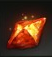

13146.775041811585
0


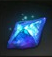

15647.220487997221
1


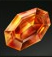

11385.04440044043
2


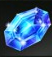

8431.355110538281
3


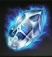

8138.376865198613
4


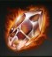

7079.892725175997
5


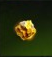

7717.5779231569795
6


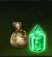

992.4419378482552
7


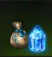

2428.1863602285553
8


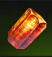

12071.724359013504
9



[1]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



[1]



[5]



[5]



[9]



[2, 2]



[9]



[9, 0, 1]



[0, 0, 2]



[9, 6]


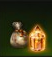

18146.487098058402
10


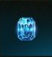

17902.620450649116
11


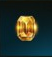

13067.828664319104
12


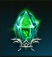

16028.94675267218
13


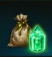

13103.019728291643
14


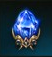

11243.861614232008
15


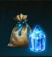

6484.472376377279
16


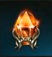

884.0237553369253
17


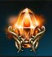

8306.24114747459
20


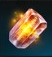

6239.4347500394615
19



[1, 9]



[5]



[9]



[4, 1]



[2, 1, 2]



[0, 2]



[0, 2, 4]



[6, 3]



[6, 8]



[1, 6, 1]


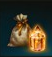

3442.5478936392446
18


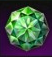

10377.760692943348
21


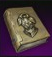

42189.233567345116
20


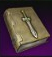

42582.325194850506
22


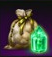

11327.04996899016
22


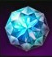

8115.648218103099
23


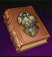

19325.858350924547
25


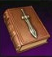

17604.07236976717
25


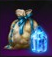

2042.7669960130058
24


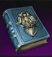

37971.76178425225
24



[9, 7, 1]



[5]



[8, 5]



[0, 9, 1]



[5, 5, 3]



[9]



[7, 4]



[0, 6, 1]



[2, 5, 6]



[8, 4, 1]


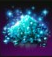

40963.59116337336
1


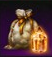

3911.180895842073
25


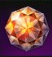

7921.116714201351
26


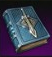

38615.6660696148
24


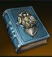

39284.551289279094
22


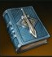

35554.33524902413
22


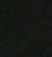

97145.16785718166
6


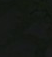

94701.6238931519
6


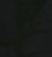

90132.1760194438
6


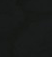

87501.29032762889
6



[7, 8, 1]



[0, 9, 2]



[0, 7, 3]



[9, 9, 3]



[0, 0, 8]



[0, 9, 6, 1]



[9, 9, 7]


In [93]:
PATH = os.path.join(cwd,"drive/Othercomputers/Mycomp/screenshots/")
pics = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]

#https://www.mathworks.com/help/matlab/ref/rgb2gray.html#d123e1274575
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def resizing(im):
  im = Image.fromarray(im)
  im = im.resize(size=(28, 28))
  im = np.array(im)
  im[im<=50] = 0 #threadholding = 50
  return im

def predict(data,device,model):
  data = data.to(device)
  out = model(data)
  pred = torch.max(out.data, 1)[1]
  return pred


pics.sort(reverse = True) #most recent file first
#print(pics)
pages = 4
coord = np.zeros((pages,10,2))
pics = pics[:pages+1] #most recent 5 pics
pics.sort()
print(pics)
items = 10 #4 for 4th page
prices = np.zeros((pages, items))
for page,f in enumerate(pics):
  imgPATH = os.path.join(PATH,f)
  img = cv2.imread(imgPATH)
  if page < 4:
    get_item_pic(img,itemTable,coord,page)
  img = rgb2gray(img)
  if page == 4: #last page is crystal price page
    crystal = get_crystal_price(img,device,model)
  else:
    get_prices(img,device,model,prices,page)

In [94]:
#Item table creation code
"""
cwd = os.getcwd()
tablePath = os.path.join(cwd,"drive/My Drive/LAO/itemTable.npy")
itemTable = np.zeros((27,3))
tempTable = np.zeros((50,3))
for page,f in enumerate(pics):
  y_st = 484 #starting y coordinate
  y_ed = 541 #ending y coordinate
  y_gap = y_ed - y_st 
  imgPATH = os.path.join(PATH,f)
  img = cv2.imread(imgPATH)
  for i in range(10):
    cv2_imshow(img[y_st:y_ed,873:925,:])
    print(np.sum(img[y_st:y_ed,873:925,0]))
    print(np.sum(img[y_st:y_ed,873:925,1]))
    print(np.sum(img[y_st:y_ed,873:925,2]))
    tempTable[page*10+i,0] = np.sum(img[y_st:y_ed,873:925,0])
    tempTable[page*10+i,1] = np.sum(img[y_st:y_ed,873:925,1])
    tempTable[page*10+i,2] = np.sum(img[y_st:y_ed,873:925,2])
    y_st += y_gap
    y_ed += y_gap
indexTable = [0,1,3,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,19,21,-1,-1,22,23,-1,-1,24,25,-1,-1,26]
for i in range(len(indexTable)):
  if indexTable[i] != -1:
    itemTable[indexTable[i],:] = tempTable[i,:]
np.save(tablePath,itemTable)
print(itemTable)
"""

'\ncwd = os.getcwd()\ntablePath = os.path.join(cwd,"drive/My Drive/LAO/itemTable.npy")\nitemTable = np.zeros((27,3))\ntempTable = np.zeros((50,3))\nfor page,f in enumerate(pics):\n  y_st = 484 #starting y coordinate\n  y_ed = 541 #ending y coordinate\n  y_gap = y_ed - y_st \n  imgPATH = os.path.join(PATH,f)\n  img = cv2.imread(imgPATH)\n  for i in range(10):\n    cv2_imshow(img[y_st:y_ed,873:925,:])\n    print(np.sum(img[y_st:y_ed,873:925,0]))\n    print(np.sum(img[y_st:y_ed,873:925,1]))\n    print(np.sum(img[y_st:y_ed,873:925,2]))\n    tempTable[page*10+i,0] = np.sum(img[y_st:y_ed,873:925,0])\n    tempTable[page*10+i,1] = np.sum(img[y_st:y_ed,873:925,1])\n    tempTable[page*10+i,2] = np.sum(img[y_st:y_ed,873:925,2])\n    y_st += y_gap\n    y_ed += y_gap\nindexTable = [0,1,3,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,19,21,-1,-1,22,23,-1,-1,24,25,-1,-1,26]\nfor i in range(len(indexTable)):\n  if indexTable[i] != -1:\n    itemTable[indexTable[i],:] = tempTable[i,:]\nnp.save(tablePath,i

In [95]:
print(prices)
print(crystal)
print(coord)
#for f in pics:
#  imgPATH = os.path.join(PATH,f)
#  img = cv2.imread(imgPATH)
#  img = rgb2gray(img)
#  cv2_imshow(img)
final_prices = np.zeros(27)
minV = np.zeros(27)
for i in range(pages):
  for j in range(10):
    if minV[int(coord[i,j,1])] == 0 or minV[int(coord[i,j,1])] > int(coord[i,j,0]):
      minV[int(coord[i,j,1])] = int(coord[i,j,0])
      final_prices[int(coord[i,j,1])] = int(prices[i,j])
print(final_prices)

[[1.00e+00 1.00e+00 5.00e+00 5.00e+00 9.00e+00 2.20e+01 9.00e+00 1.09e+02
  2.00e+02 6.90e+01]
 [9.10e+01 5.00e+00 9.00e+00 1.40e+01 2.12e+02 2.00e+01 4.20e+02 3.60e+01
  8.60e+01 1.61e+02]
 [1.79e+02 5.00e+00 5.80e+01 1.90e+02 3.55e+02 9.00e+00 4.70e+01 1.60e+02
  6.52e+02 1.48e+02]
 [1.87e+02 2.90e+02 3.70e+02 3.99e+02 8.00e+02 1.69e+03 0.00e+00 0.00e+00
  0.00e+00 0.00e+00]]
799
[[[1.31467750e+04 0.00000000e+00]
  [1.56472205e+04 1.00000000e+00]
  [1.13850444e+04 2.00000000e+00]
  [8.43135511e+03 3.00000000e+00]
  [8.13837687e+03 4.00000000e+00]
  [7.07989273e+03 5.00000000e+00]
  [7.71757792e+03 6.00000000e+00]
  [9.92441938e+02 7.00000000e+00]
  [2.42818636e+03 8.00000000e+00]
  [1.20717244e+04 9.00000000e+00]]

 [[1.81464871e+04 1.00000000e+01]
  [1.79026205e+04 1.10000000e+01]
  [1.30678287e+04 1.20000000e+01]
  [1.60289468e+04 1.30000000e+01]
  [1.31030197e+04 1.40000000e+01]
  [1.12438616e+04 1.50000000e+01]
  [6.48447238e+03 1.60000000e+01]
  [8.84023755e+02 1.70000000e+01]
 

In [96]:
f = open(dbPATH, 'r')
dbcode = f.readline()
f.close()

client = pymongo.MongoClient(dbcode)
print(client.stats)
for db in client.list_databases():
    print(db)
db = client.LAO
for collection in db.list_collection_names():
    print(collection)
collection = db.maris

Database(MongoClient(host=['lao-shard-00-00.zskci.mongodb.net:27017', 'lao-shard-00-01.zskci.mongodb.net:27017', 'lao-shard-00-02.zskci.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='atlas-i30wmu-shard-0', tls=True), 'stats')
{'name': 'LAO', 'sizeOnDisk': 73728, 'empty': False}
{'name': 'admin', 'sizeOnDisk': 348160, 'empty': False}
{'name': 'local', 'sizeOnDisk': 633376768, 'empty': False}
maris


In [97]:
items = {
    "id" : "TEMPO",
    "crystal" : crystal,
    "i1" : {
        "name" : "Destruction Stone Fragment",
        "price" : final_prices[0]
    },
    "i2" : {
        "name" : "Guardian Stone Fragment",
        "price" : final_prices[1]
    },
    "i3" : {
        "name" : "Destruction Stone",
        "price" : final_prices[2]
    },
    "i4" : {
        "name" : "Guardian Stone",
        "price" : final_prices[3]
    },
    "i5" : {
        "name" : "Guardian Stone Crystal",
        "price" : final_prices[4]
    },
    "i6" : {
        "name" : "Destruction Stone Crystal",
        "price" : final_prices[5]
    },
    "i7" : {
        "name" : "Simple Oreha Fusion Material",
        "price" : final_prices[6]
    },
    "i8" : {
        "name" : "Harmony Shard Pouch (S)",
        "price" : final_prices[7]
    },
    "i9" : {
        "name" : "Life Shard Pouch (S)",
        "price" : final_prices[8]
    },
    "i10" : {
        "name" : "Solar Grace",
        "price" : final_prices[9]
    },
    "i11" : {
        "name" : "Honor Shard Pouch (S)",
        "price" : final_prices[10]
    },
    "i12" : {
        "name" : "Caldarr Fusion Material",
        "price" : final_prices[11]
    },
    "i13" : {
        "name" : "Basic Oreha Fusion Material",
        "price" : final_prices[12]
    },
    "i14" : {
        "name" : "Harmony Leapstone",
        "price" : final_prices[13]
    },
    "i15" : {
        "name" : "Harmony Shard Pouch (M)",
        "price" : final_prices[14]
    },
    "i16" : {
        "name" : "Life Leapstone",
        "price" : final_prices[15]
    },
    "i17" : {
        "name" : "Life Shard Pouch (M)",
        "price" : final_prices[16]
    },
    "i18" : {
        "name" : "Honor Leapstone",
        "price" : final_prices[17]
    },
    "i19" : {
        "name" : "Honor Shard Pouch (M)",
        "price" : final_prices[18]
    },
    "i20" : {
        "name" : "Solar Blessing",
        "price" : final_prices[19]
    },
    "i21" : {
        "name" : "Great Honor Leapstone",
        "price" : final_prices[20]
    },
    "i22" : {
        "name" : "Star's Breath",
        "price" : final_prices[21]
    },
    "i23" : {
        "name" : "Harmony Shard Pouch (L)",
        "price" : final_prices[22]
    },
    "i24" : {
        "name" : "Moon's Breath",
        "price" : final_prices[23]
    },
    "i25" : {
        "name" : "Life Shard Pouch (L)",
        "price" : final_prices[24]
    },
    "i26" : {
        "name" : "Honor Shard Pouch (L)",
        "price" : final_prices[25]
    },
    "i27" : {
        "name" : "Solar Protection",
        "price" : final_prices[26]
    }
}

In [98]:
collection.delete_many( { 'id': "TEMPO" } )
collection.insert_one(items).inserted_id

ObjectId('62aec62c6730252bcf0f1ffb')